In [1]:
import os
import random
import numpy as np
import jax
import flax.linen as nn
from jax import grad, value_and_grad
import jax.numpy as jnp
from flax.core.frozen_dict import freeze
import optax
import datasets
from datasets import load_dataset
import matplotlib.pyplot as plt
from flax.training import train_state, checkpoints
from colormaps import create_ade20k_label_colormap
import augmax
import orbax.checkpoint as orbax
from unet_model import _unet
from loss_functions import dice_loss, dice_loss_and_preds
from preprocessing_functions import prep_data_batch, grads_zeroed
from plotting_functions import plot_pred_and_target
import nest_asyncio
nest_asyncio.apply()

2023-01-27 19:42:07.658630: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-27 19:42:08.765157: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2023-01-27 19:42:08.765329: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2023-01-27 19:42:08.765336: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned a

In [2]:
dataset = load_dataset("scene_parse_150")
train_dataset, test_dataset, val_dataset  = dataset["train"], dataset["test"], dataset["validation"]
# Number of segmentation classes
num_classes = 151
# Image height and width
height, width = 256, 256
# Location for saving and loading checkpoints
checkpoint_dir = "./checkpoints/u-net/"
os.makedirs(checkpoint_dir, exist_ok=True)

  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# Create the model object
unet = _unet(num_classes)
# Display the model details
dummy_x = np.array(train_dataset[0]["image"])
# Downsample the image
dummy_x = jax.image.resize(dummy_x, shape=(height, width, 3), method="bilinear")
rng_key = jax.random.PRNGKey(64)

In [4]:
augment_images = jax.jit(augmax.Chain(
  augmax.RandomContrast(range=(0, 0.3), p=1.0),
  augmax.RandomBrightness(range=(-0.6, 0.6), p=1.0),
))

Epoch: 0
		Validation Loss: 0.74


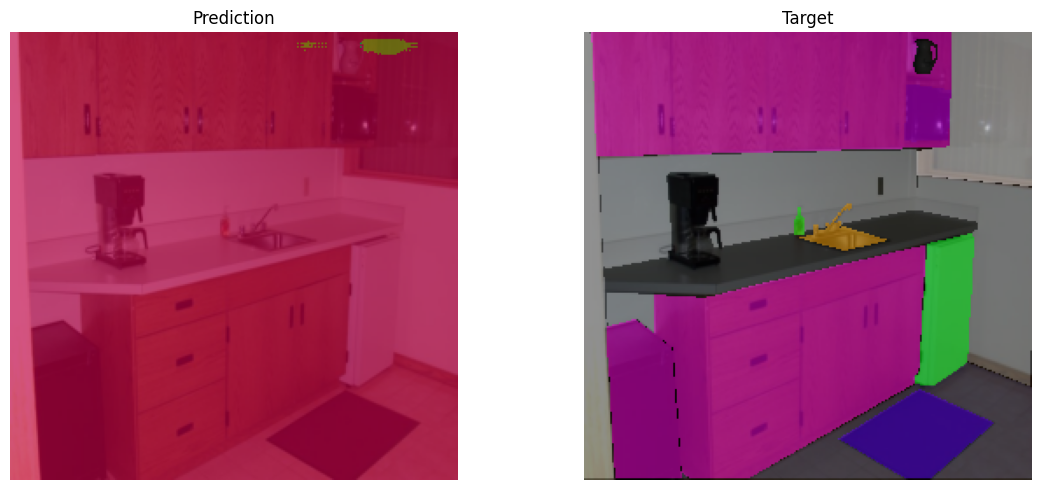

	Loss: 0.74
Epoch: 100
	Loss: 0.73
Epoch: 200
	Loss: 0.73
Epoch: 300
	Loss: 0.73
Epoch: 400
	Loss: 0.72
Epoch: 500
		Validation Loss: 0.74


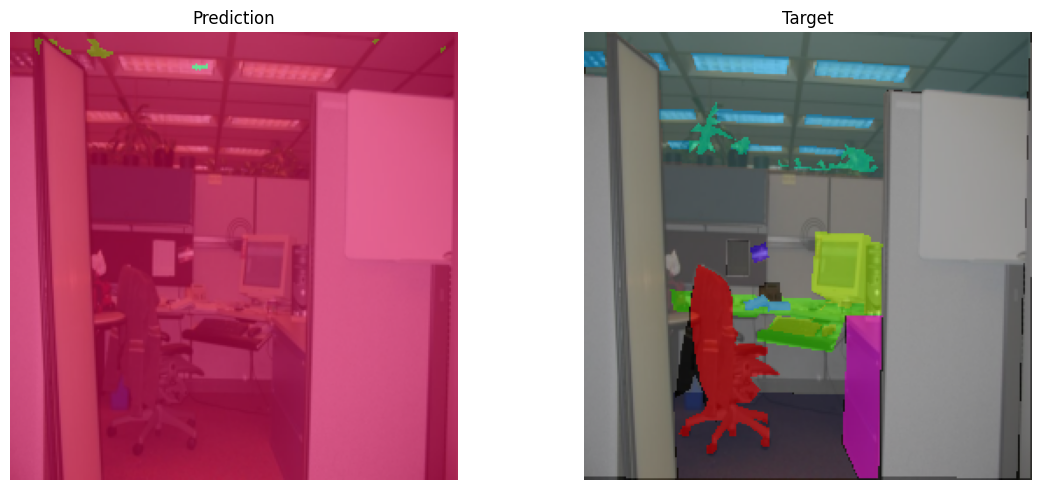

	Loss: 0.72
Epoch: 600
	Loss: 0.71
Epoch: 700
	Loss: 0.71
Epoch: 800
	Loss: 0.71
Epoch: 900
	Loss: 0.71
Epoch: 1000
		Validation Loss: 0.70


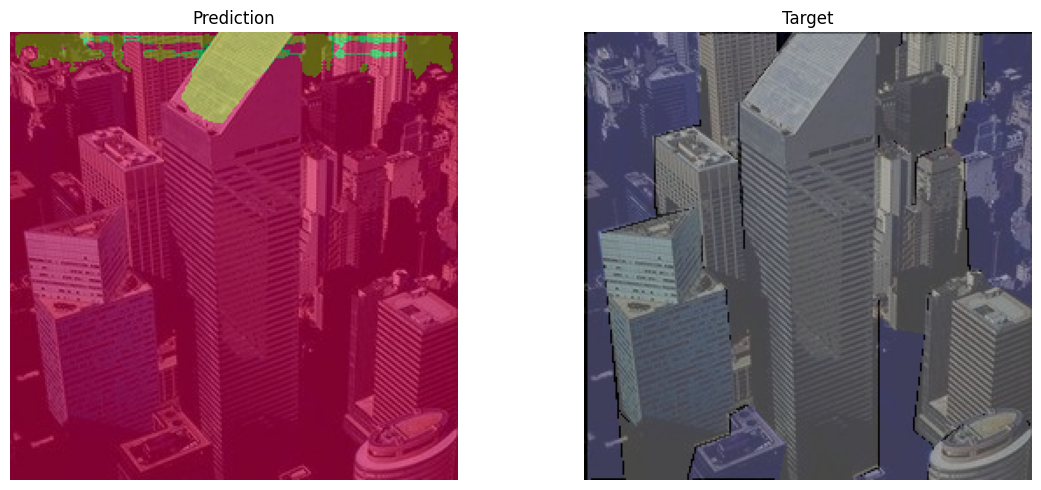

	Loss: 0.71
Epoch: 1100
	Loss: 0.71
Epoch: 1200
	Loss: 0.71
Epoch: 1300
	Loss: 0.71
Epoch: 1400
	Loss: 0.70
Epoch: 1500
		Validation Loss: 0.70


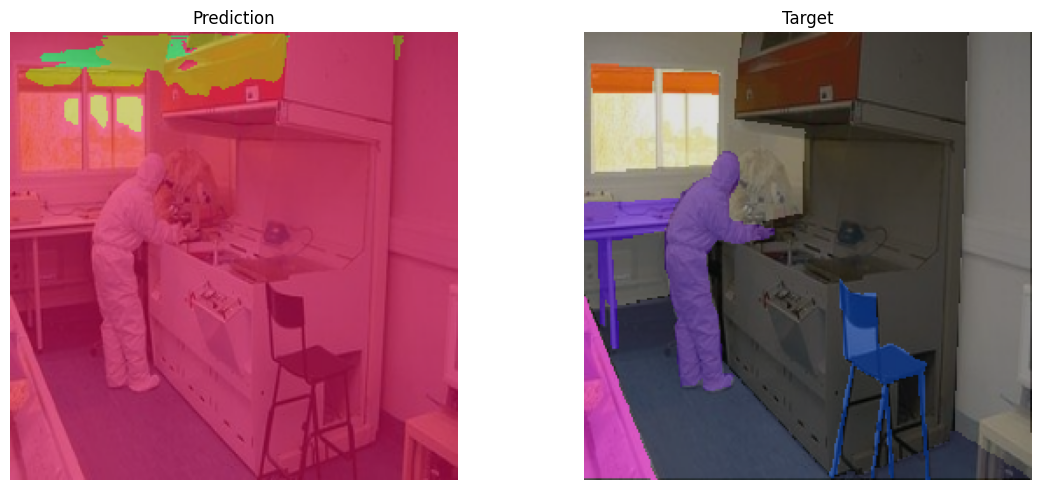

	Loss: 0.70
Epoch: 1600
	Loss: 0.70
Epoch: 1700
	Loss: 0.69
Epoch: 1800
	Loss: 0.69
Epoch: 1900
	Loss: 0.69
Epoch: 2000
		Validation Loss: 0.68


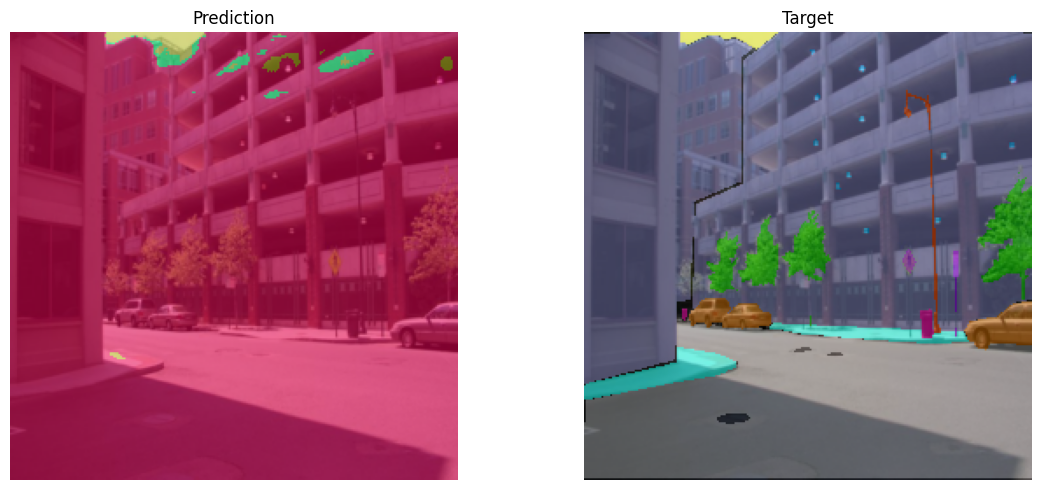

	Loss: 0.69
Epoch: 2100
	Loss: 0.68
Epoch: 2200
	Loss: 0.68
Epoch: 2300
	Loss: 0.67


: 

: 

In [6]:
# Number of training epochs
epochs = 2300
# Display training loss frequency
print_freq = 100
# Validation frequency
val_epochs = 500
# Checkpointing frequency
save_steps = 100
batch_size = 1
# A small number to prevent loss function from dividing by zero
epsilon = 0.0001
# Exponential decay learning rate schedule defined by:
# learning_rate * decay_rate ^ (global_step / decay_steps)
schedule = optax.exponential_decay(
    init_value=0.01,
    transition_steps=100,
    decay_rate=0.99,
    transition_begin=1000,
    end_value=0.00001,
)
optimizer = optax.adam(learning_rate=schedule)

# Restore latest checkpoint
restore_latest = True
orbax_checkpointer = orbax.Checkpointer(orbax.PyTreeCheckpointHandler())

variables = unet.init(rng_key, dummy_x)
state = train_state.TrainState.create(
    apply_fn=unet.apply,
    params=variables['params'], 
    tx=optimizer,
)

if restore_latest:
    state = checkpoints.restore_checkpoint(
        ckpt_dir=checkpoint_dir, 
        target=state, 
        orbax_checkpointer=orbax_checkpointer
    )

train_data_generator = train_dataset.iter(batch_size=1)
val_data_generator = val_dataset.iter(batch_size=1)

losses = []
val_losses = []

for epoch in range(epochs + 1):
    if epoch % print_freq == 0: print(f"Epoch: {epoch}")
    # Evaluate the models performance
    if epoch % val_epochs == 0:
        # Prepare a batch of data
        val_inputs, val_targets = prep_data_batch(val_data_generator, batch_size, height, width, num_classes)
        # Perform augmentation
        rng_key, subkey = jax.random.split(rng_key)
        val_inputs = augment_images(subkey, val_inputs)
        # Get loss and preds
        val_loss, val_preds = dice_loss_and_preds(freeze({"params": state.params}), state, val_inputs, val_targets, epsilon)
        val_losses.append(val_loss)
        print(f"\t\tValidation Loss: {val_loss :.2f}")
        # Plot the segmentation predictions
        for val_index in range(batch_size):
            val_input = val_inputs[val_index]
            val_pred = val_preds[val_index]
            plot_pred_and_target(val_input, val_pred, val_targets[val_index])

    # Prepare a batch of data
    inputs, targets = prep_data_batch(train_data_generator, batch_size, height, width, num_classes)
    # Perform augmentation
    rng_key, subkey = jax.random.split(rng_key)
    inputs = augment_images(subkey, inputs)
    # Perform backpropagation 
    variables = freeze({"params": state.params})
    loss, grads = value_and_grad(dice_loss, argnums=0)(variables, state, inputs, targets, epsilon)
    if grads_zeroed(grads):
        print("Gradients are zeroed, exiting training run now...")
        break

    state = state.apply_gradients(grads=grads["params"])

    losses.append(loss)
    last_mean_loss = np.array(losses[-print_freq:]).mean()
    if epoch % print_freq == 0: print(f"\tLoss: {last_mean_loss :.2f}")

    if epoch % save_steps == 0:
        checkpoints.save_checkpoint(
            ckpt_dir=checkpoint_dir, 
            target=state, 
            step=epoch,
            overwrite=True,
            keep=4,
            orbax_checkpointer=orbax_checkpointer
            )


    

ValueError: v cannot be empty

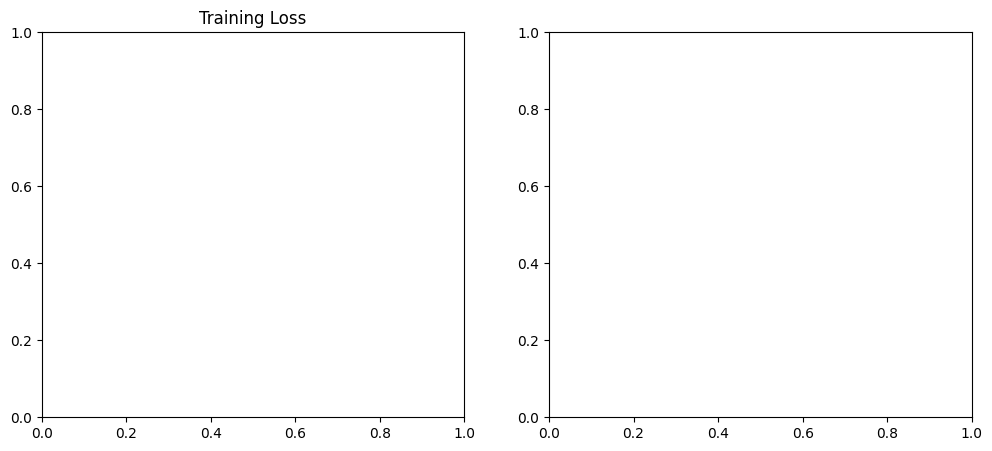

In [ ]:
epoch_window = 5
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axs[0].set_title("Training Loss")
loss_moving_average = (
    np.convolve(
        np.array(losses), np.ones(epoch_window), mode="valid"
    )
    / epoch_window
)
axs[0].plot(range(len(loss_moving_average)), loss_moving_average)
axs[1].set_title("Validation Loss")
val_loss_moving_average = (
    np.convolve(
        np.array(val_losses), np.ones(epoch_window), mode="valid"
    )
    / epoch_window
)
axs[1].plot(range(len(val_loss_moving_average)), val_loss_moving_average)
plt.tight_layout()
plt.show()